In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Imports
import csv
import sys
import h5py
import timeit
import qutip as qt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# QOGS
home      = Path.home()
qogs_root = home / "Documents/Yale/Research/Girvin/QOGS"
sys.path.insert(0, str(qogs_root))
from QOGS.gate_sets import GRAPE
from QOGS.optimizer.tf_adam_optimizer import AdamOptimizer


Need tf version 2.3.0 or later. Using tensorflow version: 2.18.0



In [ ]:
# System Definitions
dim_qubit     = 2
dim_resonator = 7
N_fock        = 4       
g             = 0.00028 * 2 * np.pi  # GHz→rad/ns
DAC_dt        = 4       # ns per slice
pulse_length  = 5000    # total ns
dim            = dim_qubit * dim_resonator

# Operators
q  = qt.tensor(qt.destroy(dim_qubit), qt.qeye(dim_resonator))
r  = qt.tensor(qt.qeye(dim_qubit), qt.destroy(dim_resonator))
qd, rd = q.dag(), r.dag()

H0  = g * (rd*q + r*qd)
Hcx =      (q + qd)
Hcy = 1j * (q - qd)

# Superposition 
psi_plus  = (qt.basis(dim_resonator, 0) + qt.basis(dim_resonator, N_fock)).unit()
psi_minus = (qt.basis(dim_resonator, 0) - qt.basis(dim_resonator, N_fock)).unit()

init_states = [
    qt.tensor(qt.basis(dim_qubit, 1), psi_plus),
    qt.tensor(qt.basis(dim_qubit, 1), psi_minus)
]
final_states = [
    qt.tensor(qt.basis(dim_qubit, 0), qt.basis(dim_resonator, 0)),
    qt.tensor(qt.basis(dim_qubit, 1), qt.basis(dim_resonator, 0))
]

# File
data_dir  = home / "Documents/Yale/Research/Chu/HyQu - Rumman"
h5_file   = data_dir / "GRAPE_control.h5"

In [ ]:
# GRAPE
synth_params = {
    "N_blocks"      : int(pulse_length / DAC_dt),
    "N_multistart"  : 45,
    "epochs"        : 1000,
    "epoch_size"    : 1,
    "learning_rate" : tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                           [50,250], [0.2,0.2,0.1]
                       ),
    "term_fid"      : 0.9995,
    "dfid_stop"     : -1,
    "initial_states": init_states,
    "target_states" : final_states,
    "coherent"      : True,
    "filename"      : None,
}

gate_set_params = {
    "H_static"     : H0,
    "H_control"    : [Hcx, Hcy],
    "DAC_delta_t"  : DAC_dt,
    "inplace"      : False,
    "scale"        : 5,
    "bandwidth"    : 0.1/2,
    "gatesynthargs": synth_params
}

GRAPE_gate_set = GRAPE(**gate_set_params)
opt = AdamOptimizer(GRAPE_gate_set)
opt.optimize()

In [ ]:
import pandas as pd

# Save as CSV
def h5_to_expanded_csv(h5_filepath, csv_filepath):
    with h5py.File(h5_filepath, 'r') as f:
        key = list(f.keys())[-1]
        pulse_obj = f[key]
        fids = pulse_obj['fidelities'][:]
        pulse_idx = np.argmax(np.amax(fids, axis=0))
        I_pulse = pulse_obj['I0'][-1, pulse_idx, :] * 1000
        Q_pulse = pulse_obj['Q0'][-1, pulse_idx, :] * 1000
        
        expanded_rows = []
        for i, q in zip(I_pulse, Q_pulse):
            for _ in range(4):
                expanded_rows.append([i, q])
        
        expanded_df = pd.DataFrame(expanded_rows)
        expanded_df.insert(0, 'Time', range(len(expanded_df)))
        expanded_df.to_csv(csv_filepath, index=False, header=False)
        print(f"Modified CSV has been saved to {csv_filepath}")
        
h5_filepath = home / "Documents/Yale/Research/Chu/HyQu - Rumman" / "GRAPE_control.h5"
csv_filepath = home / "Documents/Yale/Research/Chu/HyQu - Rumman" / "0+4_reverse.csv"
h5_to_expanded_csv(h5_filepath, csv_filepath)

In [ ]:
csv_filepath = home / "Documents/Yale/Research/Chu/HyQu - Rumman" / "0+3_reverse.csv"

# Load I/Q 
rows = []
with open(csv_filepath, "r") as f:
    reader = csv.reader(f, delimiter=',')
    for r in reader:
        rows.append(r)

times_ns = np.array([float(r[0]) for r in rows])       
times    = times_ns / 1000.0      # now in μs
I_rev    = np.array([float(r[1]) for r in rows])           
Q_rev    = np.array([float(r[2]) for r in rows])         

dt = times[1] - times[0]                               
print(f"Loaded {len(times)} points, dt = {dt*1e3:.1f} ns")

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_facecolor('whitesmoke')
ax.plot(times, I_rev, label='I')
ax.plot(times, Q_rev, label='Q')
ax.set_xlabel(r"Time  [$\mu$s]")
ax.set_ylabel('Amplitude Ω [MHz]')
ax.set_title('Control Pulses: I & Q vs Time (μs)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### Matteo Fidelity Simulation

In [ ]:
# General
cm = 1 / 2.54
pi2 = np.pi * 2

# Parameters       
alpha = 190 * pi2      # Transmon anharmonicity
T1q = 26               # In μs
T1p = 98.80            # In μs
T2q = 20               # In μs
g1q = 1/T1q            # Qubit decay 
g1p = 1/T1p            # Phonon decay
gphiq = 1/T2q          # Qubit dephasing 
ga = 0.283 * pi2       # In MHz

# System                                     
Id = qt.tensor(qt.qeye(dim_qubit), qt.qeye(dim_resonator))
q = qt.tensor(qt.destroy(dim_qubit), qt.qeye(dim_resonator))
p = qt.tensor(qt.qeye(dim_qubit), qt.destroy(dim_resonator))
qd = q.dag()
pd = p.dag()

csv_filepath = home / "Documents/Yale/Research/Chu/HyQu - Rumman" / "0+3_reverse.csv"

with open(csv_filepath, "r") as f:
    rows = list(csv.reader(f, delimiter=","))
ReOmega = np.array([[float(r[0]) / 1000, float(r[1])] for r in rows])
ImOmega = np.array([[float(r[0]) / 1000, float(r[2])] for r in rows])

timesFromOC = list(ReOmega[:,0])
T = timesFromOC[-1]                 
nt = len(timesFromOC)                
dt = timesFromOC[1]-timesFromOC[0]   
print(f'dt = {dt * 1e3:.3f}ns')
times_1 = timesFromOC
step = 10

def create_hamiltonian(amp):
    Hq = 0 * qd*q - alpha/2 * qd*qd*q*q
    Hph = 0 * pd * p
    Hcoupling = ga * (pd * q + p * qd)
    Hdrive = [[amp * (q + qd), ReOmega[:,1]], [amp * (1j*(q - qd)), ImOmega[:,1]]]
    H = [Hq + Hph + Hcoupling, *Hdrive]
    return H

def simulate_hamiltonian(H,rho0, c_ops = [np.sqrt(g1p) * p, np.sqrt(g1q) * q, np.sqrt(2*gphiq) * qd*q], e_ops = []):
    options = qt.Options(nsteps=500000, atol=1e-8, rtol=1e-6)
    tic = timeit.default_timer()
    res = qt.mesolve(H, rho0, times_1, c_ops=c_ops, e_ops=[], args=None, options=options, progress_bar=True)
    toc = timeit.default_timer()
    print(f'mesolve time: {toc - tic:.1f}s')
    res_rho = res.states
    return res_rho

def compute_dm(res_rho):  
    tt = [ t for t in times_1[::step] ]
    gg = []
    ee = []
    g0 = []
    g1 = []
    e0 = []
    e1 = []
    
    for rho in tqdm(res_rho[::step]):   
        gg.append(qt.expect(qt.tensor((qt.basis(dim_qubit,0)).proj(), qt.qeye(dim_resonator)), rho))
        ee.append(qt.expect(qt.tensor((qt.basis(dim_qubit,1)).proj(), qt.qeye(dim_resonator)), rho))
        g0.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,0), qt.basis(dim_resonator,0))).proj() , rho))
        g1.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,0), qt.basis(dim_resonator,1))).proj() , rho))
        e0.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,1), qt.basis(dim_resonator,0))).proj() , rho))
        e1.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,1), qt.basis(dim_resonator,1))).proj() , rho))

    rhofin = res_rho[-1]
    try:
        fig, ax = qt.hinton(qt.ket2dm(rhofin))
    except:
        fig, ax = qt.hinton(rhofin)
    plt.show()
    
    return tt, gg, ee, g0, g1, e0, e1

H = create_hamiltonian(1)
psi_plus = (qt.basis(dim_resonator, 0) + qt.basis(dim_resonator, N_fock)).unit()
psi_minus = (qt.basis(dim_resonator, 0) - qt.basis(dim_resonator, N_fock)).unit()
rho_plus     = qt.ket2dm(qt.tensor(qt.basis(dim_qubit, 1), psi_plus))
rho_minus    = qt.ket2dm(qt.tensor(qt.basis(dim_qubit, 1), psi_minus))
rho_plustarget = qt.ket2dm(
    qt.tensor(
        qt.basis(dim_qubit, 0),
        qt.basis(dim_resonator, 0)
    )
)
rho_minustarget = qt.ket2dm(
    qt.tensor(
        qt.basis(dim_qubit, 1),
        qt.basis(dim_resonator, 0)
    )
)
sim_res_plus = simulate_hamiltonian(H,rho_plus)
sim_res_minus = simulate_hamiltonian(H,rho_minus)
print(f"Fidelity : {qt.fidelity(sim_res_plus[-1], rho_plustarget)}")
print(f"Fidelity : {qt.fidelity(sim_res_minus[-1], rho_minustarget)}")
tt, gg, ee, g0, g1, e0, e1 = compute_dm(sim_res_plus)
tt, gg, ee, g0, g1, e0, e1 = compute_dm(sim_res_minus)

### Full Protocol

In [ ]:
# Forward pulse
def run_forward_pulse(rho_in, csv_path, dim_q=2, dim_r=6, g=0.28 * 2 * np.pi):
    q  = qt.tensor(qt.destroy(dim_q), qt.qeye(dim_r))
    r  = qt.tensor(qt.qeye(dim_q), qt.destroy(dim_r))
    qd, rd = q.dag(), r.dag()

    H0  = g * (rd*q + r*qd)
    Hcx =      (q + qd)
    Hcy = 1j * (q - qd)

    rows  = np.asarray(list(csv.reader(open(csv_path), delimiter=",")), dtype=float)
    tlist = rows[:,0] / 1000.0
    Re    = rows[:,1]
    Im    = rows[:,2]

    H_td  = [H0, [Hcx, Re], [Hcy, Im]]
    opts  = qt.Options(nsteps=200000, atol=1e-8, rtol=1e-6)
    res   = qt.mesolve(H_td, rho_in, tlist, c_ops=[], options=opts, progress_bar=None)
    return res.states[-1]


# Phase rotation
def apply_phase_rotation(rho_in, theta, dim_q=2, dim_r=6):
    n_res = qt.tensor(qt.qeye(dim_q), qt.destroy(dim_r).dag() * qt.destroy(dim_r))
    U = (-1j * theta * n_res).expm()
    if U.dims != rho_in.dims:
        U = qt.Qobj(U.full(), dims=rho_in.dims)
    return U * rho_in * U.dag()


# Reverse pulse 
def run_reverse_pulse(rho_in, csv_path, dim_q=2, dim_r=6, g=0.28 * 2 * np.pi):
    q  = qt.tensor(qt.destroy(dim_q), qt.qeye(dim_r))
    r  = qt.tensor(qt.qeye(dim_q), qt.destroy(dim_r))
    qd, rd = q.dag(), r.dag()

    H0  = g * (rd*q + r*qd)
    Hcx =      (q + qd)
    Hcy = 1j * (q - qd)

    rows  = np.asarray(list(csv.reader(open(csv_path), delimiter=",")), dtype=float)
    tlist = rows[:,0] / 1000.0
    Re    = rows[:,1]
    Im    = rows[:,2]

    H_td  = [H0, [Hcx, Re], [Hcy, Im]]
    opts  = qt.Options(nsteps=200000, atol=1e-8, rtol=1e-6)
    res   = qt.mesolve(H_td, rho_in, tlist, c_ops=[], options=opts, progress_bar=None)
    return res.states[-1]

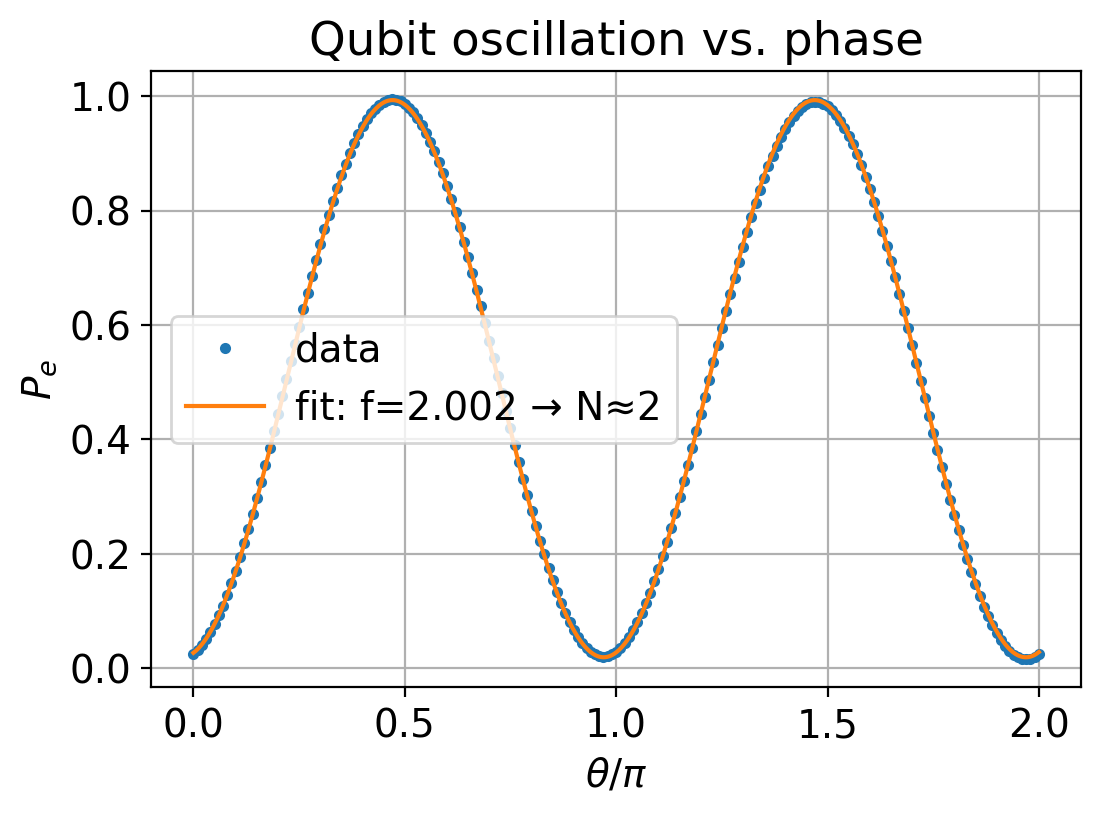

Estimated N from fit: 2 (f_fit = 2.002318)
Contrast B_fit = -0.4867, offset A_fit = 0.5062


In [ ]:
# Forward → phase → reverse, extract N from P_e(θ)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qutip as qt
from pathlib import Path

home        = Path.home()
data_dir    = home / "Documents" / "Yale" / "Research" / "Chu" / "HyQu - Rumman"
forward_csv = data_dir / "0+2_forward.csv"
reverse_csv = data_dir / "0+2_reverse.csv"

dim_q, dim_r = 2, 6
g_val        = 0.28 * 2 * np.pi

proj_e = qt.tensor(qt.basis(dim_q,1)*qt.basis(dim_q,1).dag(), qt.qeye(dim_r))
rho_g0 = qt.ket2dm(qt.tensor(qt.basis(dim_q,0), qt.basis(dim_r,0)))
rho_fwd = run_forward_pulse(rho_g0, forward_csv, dim_q=dim_q, dim_r=dim_r, g=g_val)

# sweep θ
thetas = np.linspace(0, 2*np.pi, 201)
P_e    = np.zeros_like(thetas)

for i, th in enumerate(thetas):
    rho_phase = apply_phase_rotation(rho_fwd, th, dim_q=dim_q, dim_r=dim_r)
    rho_out   = run_reverse_pulse(rho_phase, reverse_csv, dim_q=dim_q, dim_r=dim_r, g=g_val)
    P_e[i]    = qt.expect(proj_e, rho_out)

# fit P_e(θ) = A + B cos(f θ + φ)  to extract f ≡ N
def cos_model(theta, A, B, f, phi):
    return A + B*np.cos(f*theta + phi)

p0 = [P_e.mean(), (P_e.max()-P_e.min())/2, 2.0, 0.0]  
popt, _ = curve_fit(cos_model, thetas, P_e, p0=p0)
A_fit, B_fit, f_fit, phi_fit = popt
N_est = round(f_fit)

# plot
theta_fine = np.linspace(0, 2*np.pi, 1000)
P_fit = cos_model(theta_fine, *popt)

plt.figure(figsize=(6,4))
plt.plot(thetas/np.pi, P_e, 'o', ms=3, label='data')
plt.plot(theta_fine/np.pi, P_fit, '-', label=f'fit: f={f_fit:.3f} → N≈{N_est}')
plt.xlabel(r"$\theta/\pi$")
plt.ylabel(r"$P_e$")
plt.title("Qubit oscillation vs. phase")
plt.grid(True)
plt.legend()
plt.show()

print(f"Estimated N from fit: {N_est} (f_fit = {f_fit:.6f})")
print(f"Contrast B_fit = {B_fit:.4f}, offset A_fit = {A_fit:.4f}")

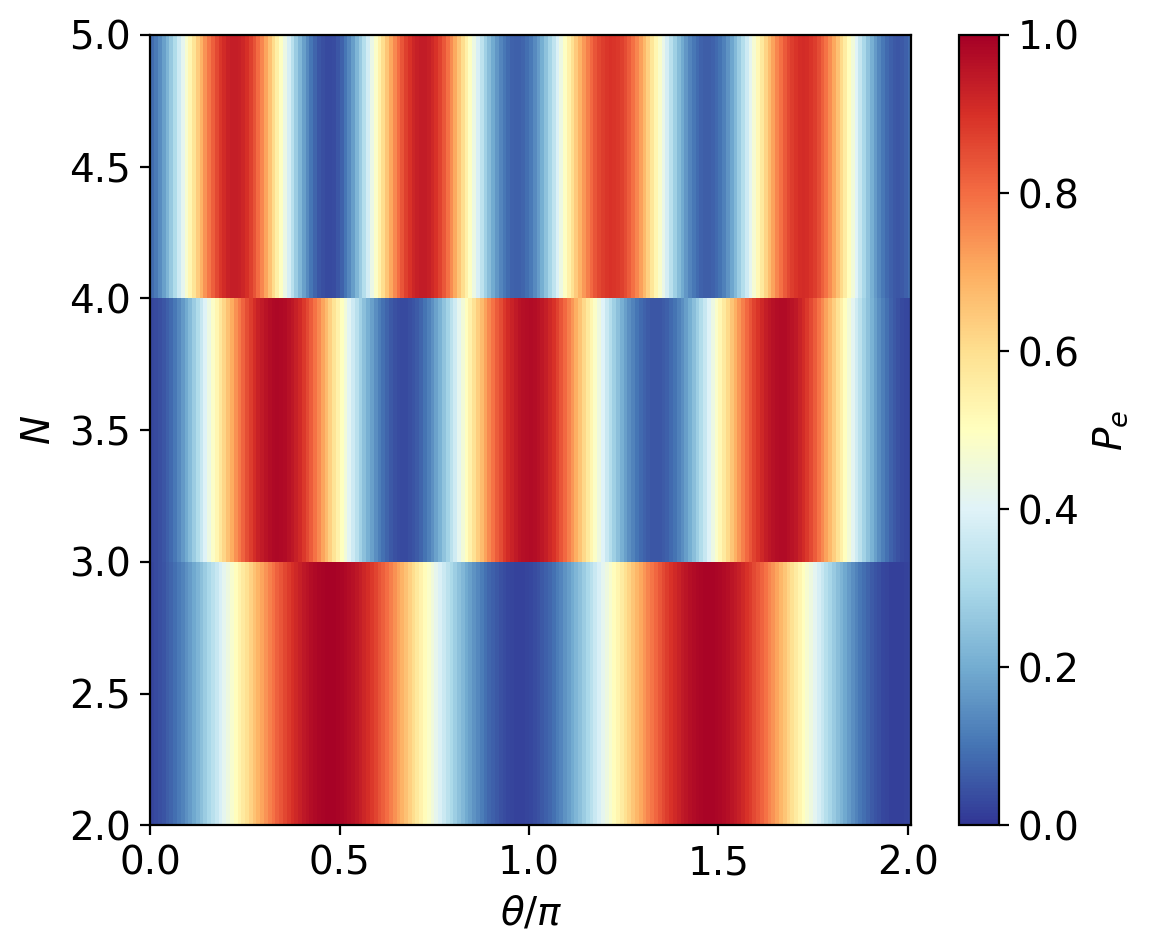

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from pathlib import Path

home     = Path.home()
data_dir = home / "Documents/Yale/Research/Chu/HyQu - Rumman"
proj_e   = qt.tensor(qt.basis(2,1)*qt.basis(2,1).dag(), qt.qeye(6))

N_list   = [2,3,4]
thetas   = np.linspace(0, 2*np.pi, 201)

Pmap = np.zeros((len(N_list), len(thetas)))

for i, N in enumerate(N_list):
    fwd_csv = data_dir / f"0+{N}_forward.csv"
    rev_csv = data_dir / f"0+{N}_reverse.csv"

    rho_fwd = run_forward_pulse(rho_g0, fwd_csv, dim_q=2, dim_r=6, g=0.28*2*np.pi)

    for j, th in enumerate(thetas):
        rho_phase = apply_phase_rotation(rho_fwd, th, dim_q=2, dim_r=6)
        rho_out   = run_reverse_pulse(rho_phase, rev_csv, dim_q=2, dim_r=6, g=0.28*2*np.pi)
        Pmap[i,j] = qt.expect(proj_e, rho_out)

fig, ax = plt.subplots(figsize=(6,5))
X = thetas/np.pi
Y = np.array(N_list)

Xc, Yc = np.meshgrid(
    np.concatenate([X, X[-1:]+(X[1]-X[0])]),
    np.concatenate([Y, Y[-1:]+1])
)

pcm = ax.pcolormesh(Xc, Yc, Pmap,
                    cmap="RdYlBu_r",   
                    shading="auto",
                    vmin=0, vmax=1)

ax.set_xlabel(r"$\theta/\pi$")
ax.set_ylabel("$N$")
ax.set_title("")

cbar = fig.colorbar(pcm, ax=ax, label=r"$P_e$")
plt.tight_layout()
plt.show()